In [3]:
import numpy as np
import glob
import json
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

# Maplotlib configs (mainly to use LaTeX font to have consistent fonts in publication)
import matplotlib
rcparams = {                      
    "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
    "text.usetex": True,                # use LaTeX to write all text
    "font.family": "lmodern",
    "font.serif": [],                   # blank entries should cause plots to inherit fonts from the document
    "font.sans-serif": [],
    "font.monospace": [],          
    "font.size": 12,
    "legend.fontsize": 12,         
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts becasue your computer can handle it :)
        r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
        ]
}
#matplotlib.rcParams.update(rcparams)

## On the full ('raw') images first; will try compressed & normalized images by Misha later

In [4]:
def normalize(arr):
    """
    Linear normalization
    http://en.wikipedia.org/wiki/Normalization_%28image_processing%29
    """
    arr = arr.astype('float')
    # Do not touch the alpha channel
    for i in range(3):
        minval = arr[...,i].min()
        maxval = arr[...,i].max()
        if minval != maxval:
            arr[...,i] -= minval
            arr[...,i] *= (255.0/(maxval-minval))
    return arr

In [95]:
def load_and_normalize_dataset(building_directories, with_transition_only=False):
    
    img_width = 512
    img_height = 384
    num_years = len(np.arange(2012,2018+1))
    
    # Filter out buildings with no transition years
    count = 0
    for d,directory in enumerate(building_directories):
        with open(directory + "/metadata.json", "r") as read_file:
            metadata = json.load(read_file)
            
        # Extract true transition year
        transition_year = metadata['new_roof_year']
        if( transition_year == None and with_transition_only ):
            continue
            
        count += 1

    # We're going to be using gray scale, so last dimension is 1 rather than 3 for RGB
    dataset = np.zeros( (count, num_years, img_height, img_width, 3) )
    #dataset = np.zeros( (len(building_directories), num_years, img_height, img_width, 3) )

    print("Dataset consists of %d properties"%dataset.shape[0])

    # For storing the true transition years labeled by Chris
    true_transition_years = []
    # For tracking the property location
    building_addresses = []

    # Loop over the properties
    count = 0
    for d,directory in enumerate(building_directories):

        # Extract meta info
        with open(directory + "/metadata.json", "r") as read_file:
            metadata = json.load(read_file)
        building_addresses.append(metadata['address'])

        # Extract true transition year
        transition_year = metadata['new_roof_year']
        if( transition_year == None and with_transition_only ):
            continue
            
        true_transition_years.append( int(transition_year) if transition_year != 'null' else 0 )

        # Get the images
        for y in range(num_years):

            # Load image, convert to gray scale, discard alpha channel and normalize pixel values
            #dataset[d,y] = np.array(Image.open(directory + "/%s.png"%(2012+y)).convert('LA'))[:,:,:1]/255

            img = Image.open(directory + "/%s.png"%(2012+y))
            arr = np.array(img)
            dataset[count,y] = np.array(Image.fromarray(normalize(arr).astype('uint8'),'RGBA'))[:,:,:3]

            #img = img.crop((0,0,256,256))
            #img.thumbnail((64, 64), Image.ANTIALIAS)
            #dataset[d,y] = np.array(img)[:,:,:1]/255.
            #dataset[d,y] = np.array(Image.open(directory + "/%s.png"%(2012+y)))[:,:,:3]/255

            # Normalize images
            #dataset[d,y] -= dataset[d,y].mean()
            #dataset[d,y] /= dataset[d,y].std()
            
        count += 1
    return dataset, true_transition_years, building_addresses

In [102]:
# Load dataset
building_directories = glob.glob("../../test/hard/*")
print(building_directories[1])
easy_dataset, easy_years, easy_locations = load_and_normalize_dataset(building_directories, with_transition_only=True)
print(easy_years)

../../test/hard/6052_Normandie_Ave,_Los_Angeles,_CA_90044,_USA
Dataset consists of 89 properties
[2017, 2018, 2017, 2018, 2017, 2017, 2017, 2013, 2014, 2015, 2014, 2013, 2017, 2016, 2013, 2015, 2013, 2016, 2016, 2018, 2015, 2017, 2016, 2015, 2017, 2013, 2015, 2013, 2015, 2017, 2015, 2015, 2018, 2014, 2014, 2017, 2017, 2020, 2016, 2015, 2016, 2015, 2019, 2017, 2017, 2016, 2017, 2014, 2015, 2015, 2015, 2018, 2018, 2017, 2016, 2013, 2017, 2019, 2018, 2020, 2018, 2020, 2017, 2015, 2015, 2017, 2015, 2018, 2016, 2017, 2017, 2017, 2017, 2017, 2019, 2017, 2017, 2015, 2019, 2017, 2017, 2018, 2013, 2016, 2013, 2017, 2017, 2017, 2014]


### Image demo

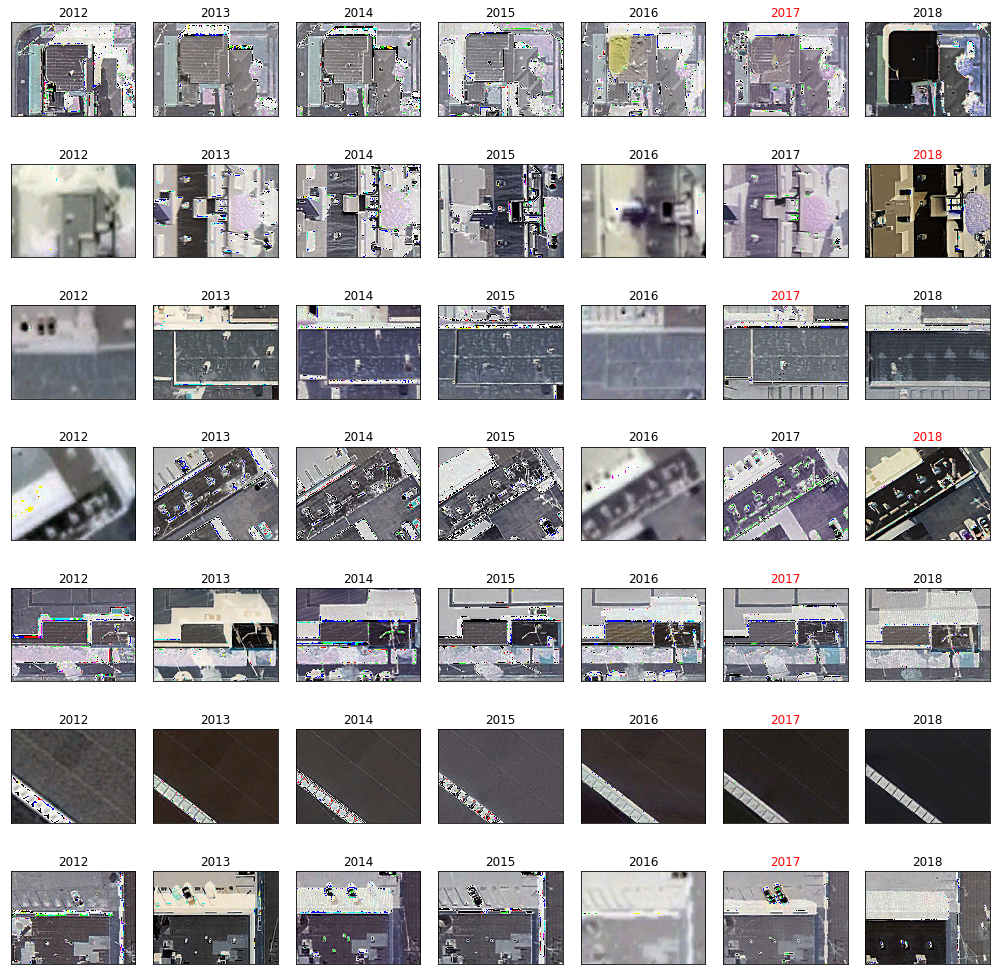

In [103]:
fig, ax = plt.subplots(7,7,figsize=(14,14))

falsedict = {'color':'black'}
truedict = {'color':'red'}

for b in range(7):
    for i in range(7):
        ax[b,i].imshow(easy_dataset[b,i])#, cmap='gray')
        ax[b,i].set_xticks([])
        ax[b,i].set_yticks([])
        ax[b,i].set_title(2012 + i, fontdict=truedict if easy_years[b] == 2012+i else falsedict)
    
fig.tight_layout()
#fig.savefig("linearnormalization.pdf")

# Largest rect intensity transition

In [104]:
import cv2
import imutils

In [105]:
def find_enclosing_rect(image):
    src = image.copy()

    # HSV thresholding to get rid of as much background as possible
    hsv = cv2.cvtColor(src.copy(), cv2.COLOR_BGR2HSV)

    lower_blue = np.array([0, 0, 120])
    upper_blue = np.array([180, 38, 255])
    mask = cv2.inRange(hsv, lower_blue, upper_blue)
    result = cv2.bitwise_and(src, src, mask=mask)
    b, g, r = cv2.split(result)
    g = clahe(g, 5, (3, 3))

    # Adaptive Thresholding
    img_blur = cv2.blur(g, (5, 5))

    img_th = cv2.adaptiveThreshold(img_blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, 101, 2)

    #g = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)

    im, contours, hierarchy = cv2.findContours(img_th,
                                               cv2.RETR_CCOMP,
                                               cv2.CHAIN_APPROX_SIMPLE)

    # Filter the rectangle by choosing only the big ones
    # and choose the brightest rectangle as the bed
    brightest_rectangle = 0
    
    max_brightness = 0
    canvas = src.copy()
    for cnt in contours:
        rect = cv2.boundingRect(cnt)
        x, y, w, h = rect
        if w*h > 40000:
            mask = np.zeros(src.shape, np.uint8)
            mask[y:y+h, x:x+w] = src[y:y+h, x:x+w]
            brightness = np.sum(mask)
            if brightness > max_brightness:
                brightest_rectangle = rect
                max_brightness = brightness

    x, y, w, h = brightest_rectangle
    
    return x,y,w,h

In [116]:
num_years = 7
brightness_data = np.zeros( (len(easy_years), num_years) )

for building in range(len(easy_years)):
    for year in range(7):
        src = np.uint8(easy_dataset[building,year])
        
        if( year == 0 ):
            
            #x,y,w,h = find_enclosing_rect(src)
            
            # HSV thresholding to get rid of as much background as possible
            hsv = cv2.cvtColor(src.copy(), cv2.COLOR_BGR2HSV)

            lower_blue = np.array([0, 0, 120])
            upper_blue = np.array([180, 38, 255])
            mask = cv2.inRange(hsv, lower_blue, upper_blue)
            result = cv2.bitwise_and(src, src, mask=mask)
            b, g, r = cv2.split(result)
            g = clahe(g, 5, (3, 3))

            # Adaptive Thresholding
            img_blur = cv2.blur(g, (10, 10))

            img_th = cv2.adaptiveThreshold(img_blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                           cv2.THRESH_BINARY, 101, 2)

            im, contours, hierarchy = cv2.findContours(img_th,
                                                       cv2.RETR_CCOMP,
                                                       cv2.CHAIN_APPROX_SIMPLE)

            # Filter the rectangle by choosing only the big ones
            # and choose the brightest rectangle as the building
            max_brightness = 0
            canvas = src.copy()
            for cnt in contours:
                rect = cv2.boundingRect(cnt)
                x, y, w, h = rect
                if w*h > 40000:
                    mask = np.zeros(src.shape, np.uint8)
                    mask[y:y+h, x:x+w] = src[y:y+h, x:x+w]
                    brightness = np.sum(mask)
                    if brightness > max_brightness:
                        brightest_rectangle = rect
                        max_brightness = brightness

            x, y, w, h = brightest_rectangle
        else:
            mask = np.zeros(src.shape, np.uint8)
            mask[y:y+h, x:x+w] = src[y:y+h, x:x+w]
            max_brightness = np.sum(mask)
        
        # Store the brightness
        brightness_data[building,year] = max_brightness
        
    brightness_data[building] = (brightness_data[building] + np.min(brightness_data[building]))
    brightness_data[building] /= np.max( brightness_data[building] )

0.258426966292


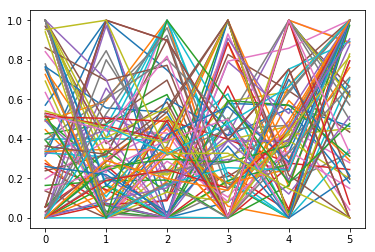

In [117]:
correct_count = 0
for building in range(len(easy_years)):
    
    deriv = np.diff(brightness_data[building])
    deriv += np.abs(np.min(deriv))
    deriv /= np.max(deriv)
        
    plt.plot(deriv)
    
    prediction = 2012+np.argmax(deriv)+1
    if( prediction == easy_years[building] ):
        correct_count += 1
        
print(correct_count/float(len(easy_years)))